- latitude (north or south) always precedes longitude (east or west)
- generating matrix

In [1]:
import requests as rq
import json
import copy
from dtocs import *

def getRadiusofEarth(lat_radian):
    r1=6378.137 #radius at equator
    r2=6356.752 #radius at poles
    a=r1*(math.cos(lat_radian))
    b=r2*(math.sin(lat_radian))
    num = (a*r1)**2 + (b*r2)**2
    den = a**2 + b**2
    rc=math.sqrt(num/den) #radius of earth at given latitude in km
    return rc*(math.cos(lat_radian)) #radius of ring at given latitude km

def getDegreeToMoveOnLat(resolution,latitude):
    # resolution in metres, latitude in degrees
    # moving on same latitude, (change in longitude)
    lat_rad=((math.pi)/180)*latitude
    rc=getRadiusofEarth(lat_rad)*1000 # in metre
    return (resolution*360)/(2*rc*math.pi)

def getDegreeToMoveOnLon(resolution):
    # resolution in metres, latitude in degrees
    # moving on same longitude, (change in latitude)
    r_earth=6371.001 # average radius of earth (in km)
    r_earth*=1000 # in metres
    return (resolution*360)/(2*r_earth*math.pi)

def genMatrix(lat1, lon1, lat2, lon2,res):
    result = []
    temp_lat = lat1
    lat_diff=getDegreeToMoveOnLon(res)

    if (lat1 < lat2 and lon1 < lon2):

        while (temp_lat < lat2):
            row = []
            temp_lon = lon1
            lon_diff=getDegreeToMoveOnLat(res,temp_lat)
            while (temp_lon < lon2):
                temp_lon += lon_diff
                row.append([temp_lat, temp_lon])
            temp_lat += lat_diff
            result.append(row)

    elif (lat1 > lat2 and lon1 < lon2):
        while (temp_lat > lat2):
            row = []
            temp_lon = lon1
            lon_diff=getDegreeToMoveOnLat(res,temp_lat)
            while (temp_lon < lon2):
                temp_lon += lon_diff
                row.append([temp_lat, temp_lon])
            temp_lat -= lat_diff
            result.append(row)

    elif (lat1 < lat2 and lon1 > lon2):
        while (temp_lat < lat2):
            row = []
            temp_lon = lon1
            lon_diff=getDegreeToMoveOnLat(res,temp_lat)
            while (temp_lon > lon2):
                temp_lon -= lon_diff
                row.append([temp_lat, temp_lon])
            temp_lat += lat_diff
            result.append(row)

    elif (lat1 > lat2 and lon1 > lon2):
        while (temp_lat > lat2):
            row = []
            temp_lon = lon1
            lon_diff=getDegreeToMoveOnLat(res,temp_lat)
            while (temp_lon > lon2):
                temp_lon -= lon_diff
                row.append([temp_lat, temp_lon])
            temp_lat -= lat_diff
            result.append(row)

    return result    

def initBinMap(x,y,n,m):
    res=[]
    for i in range(n):
        row=[]
        for j in range(m):
            row.append(math.inf)
        res.append(row)
    res[x][y]=0
    return res


Calling API

In [2]:
# import ee
# ee.Authenticate()


Successfully saved authorization token.


In [3]:
# Initialize the library.
# ee.Initialize()

In [4]:
# Import the MODIS land cover collection.
# lc = ee.ImageCollection("ESA/WorldCover/v100")

In [5]:
# Import the USGS ground elevation image.
# elv = ee.Image('USGS/SRTMGL1_003')

In [43]:
# print(type(a))

In [6]:
# # Define the urban location of interest as a point near Lyon, France.
# u_lon = 77.00124
# u_lat = 31.78702
# u_poi = ee.Geometry.Point(u_lon, u_lat)

In [7]:
# scale = 1000  # scale in meters

# # Print the elevation near Lyon, France.
# # elv_urban_point = elv.sample(p_list, scale, geometries= True).first().getInfo()
# elv_urban_point = elv.sample(u_poi, scale,geometries= True).first().getInfo()
# elevation=elv_urban_point['properties']['elevation']
# point_crd=elv_urban_point['geometry']['coordinates']
# # print('Ground elevation at point:', elv_urban_point, 'm')
# print('Ground elevation at point:', point_crd,elevation,'m')

Ground elevation at point: [77.00337232128555, 31.788547391115323] 1410 m


In [8]:
def getPointElevationEE(lat,lon):
    u_poi = ee.Geometry.Point(lon, lat)
    elv_urban_point = elv.sample(u_poi, scale,geometries= False).first().getInfo()
    elevation=elv_urban_point['properties']['elevation']
    return elevation

def getElevationMatEE(mat):
    n = len(mat)
    m = len(mat[0])
    locationDict = {'locations': []}

    count=0 

    listOfPoints=[]

    for i in range(n):
        for j in range(m):
            temp = mat[i][j]
            coord = {
                'latitude': temp[0],
                'longitude': temp[1]}
            locationDict['locations'].append(coord)
            elv=getPointElevationEE(coord['latitude'],coord['longitude'])
            listOfPoints.append(elv)

    #         if(count==1500):
    #             responseList=elevationApiResponse(locationDict)
    #             locationDict['locations'].clear()
    #             listOfPoints.extend(responseList)
    #             count=0
    # responseList=elevationApiResponse(locationDict)
    # listOfPoints.extend(responseList)

    idx = 0
    elevation_list = [] 

    for i in range(n):
        temp_row = []
        for j in range(m):
            temp_row.append(listOfPoints[idx]['elevation'])
            idx += 1
        elevation_list.append(temp_row)

    return elevation_list
    
    


In [2]:

def elevationApiResponse(pointsObj):
    apiEndPoint = "http://localhost/api/v1/lookup"
    # apiEndPoint = "http://localhost/api/v1/lookup"
    # apiEndPoint = "https://api.open-elevation.com/api/v1/lookup"
    header = {
        'Accept': 'application/json',
        'Content-Type': 'application/json'
    }

    response = rq.post(apiEndPoint, data=json.dumps(pointsObj), headers=header)
    jsonResult = response.json()
    return jsonResult['results'] # n*m  
# get elevation data using API 
def getElevation(mat):
    n = len(mat)
    m = len(mat[0])
    locationDict = {'locations': []}

    count=0 

    listOfPoints=[]

    for i in range(n):
        for j in range(m):
            count+=1
            temp = mat[i][j]
            coord = {
                'latitude': temp[0],
                'longitude': temp[1]}
            locationDict['locations'].append(coord)

            if(count==1500):
                responseList=elevationApiResponse(locationDict)
                locationDict['locations'].clear()
                listOfPoints.extend(responseList)
                count=0
    responseList=elevationApiResponse(locationDict)
    listOfPoints.extend(responseList)

    idx = 0
    elevation_list = [] 

    for i in range(n):
        temp_row = []
        for j in range(m):
            temp_row.append(listOfPoints[idx]['elevation'])
            idx += 1
        elevation_list.append(temp_row)

    return elevation_list

# def calcDistance(x1,y1,x2,y2):
#     return ((x1-x2)**2 + (y1-y2)**2)**0.5
# initilize the binary map


def initGrayLevelMatrix():
    
    # x1, y1 = 32.016592779440266, 77.3757009079523
    # x2, y2 = 31.727365814463468, 78.0129079392023

    x1, y1 = 44.32480359458633, -109.81884898177093
    x2, y2 = 44.30294042398075, -109.77537406272984

    coordinate_matrix = []
    resolution = 30 # in metres

    coordinate_matrix = genMatrix(x1, y1, x2, y2,resolution)

    elevation_map = getElevation(coordinate_matrix) #using open elevation
    # elevation_map = getElevationMatEE(coordinate_matrix) #using earth engine elevation
    return elevation_map

# def applyDistTf(elevation_map,num=4):
def applyDistTf(elevation_map,elevation_np_arr,bin_map_start,src_idx_x, src_idx_y, des_idx_x, des_idx_y,num=4):

    # solve(elevation_np_arr, bin_map_start,numOfPasses=num)
    # solve(elevation_np_arr, bin_map_end,numOfPasses=num)

    result = [[0]*m]*n
    parent_array = parents_using_start(elevation_np_arr, bin_map_start,numOfPasses=num)

    
    while(des_idx_x != src_idx_x and des_idx_y != src_idx_y){
        
    }

    plt.imshow(elevation_map,cmap='gray')
    plt.title("Gray Level")
    plt.show()

    plt.imshow(bin_map_start,cmap='gray')
    plt.title("F1")
    plt.show()

    # plt.imshow(bin_map_end,cmap='gray')
    # plt.title("F2")
    # plt.show()




SyntaxError: invalid syntax (Temp/ipykernel_17628/2676846873.py, line 82)

In [62]:
elevation_map=initGrayLevelMatrix()

In [63]:
elevation_np_arr = np.array(elevation_map)
n,m=elevation_np_arr.shape
print(f"Gray Map Shape: {elevation_np_arr.shape}")
# print(elevation_np_arr)
# run the pass

src_idx_x=20
src_idx_y=20
des_idx_x=n-15
des_idx_y=m-15

src_idx_x, src_idx_y = 44.32480359458633, -109.81884898177093
des_idx_x, des_idx_y = 44.30294042398075, -109.77537406272984

bin_map_start = initBinMap(src_idx_x,src_idx_y,n,m)   
# bin_map_end = initBinMap(des_idx_x,des_idx_y,n,m)

Gray Map Shape: (1073, 2003)


In [64]:
elevation_np_arr.min()
elevation_np_arr.max()
# elevation_np_arr

6197

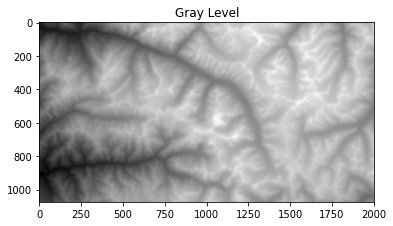

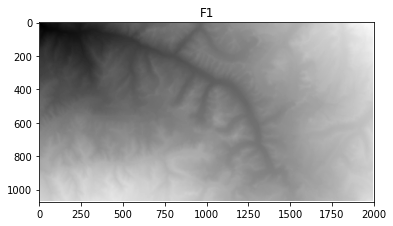

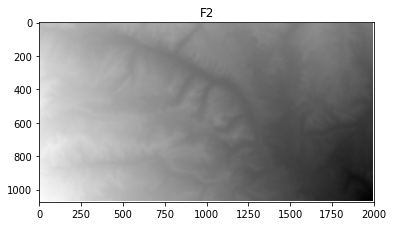

In [65]:
# applyDistTf(elevation_map,10)
applyDistTf(elevation_map,elevation_np_arr, bin_map_start, src_idx_x, src_idx_y, des_idx_x, des_idx_y, 10)


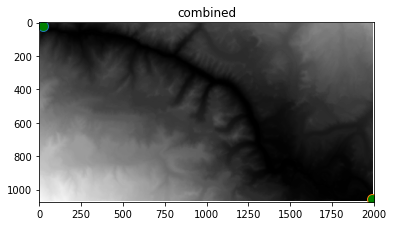

In [66]:
bin_map_combined=copy.deepcopy(bin_map_start)

n=len(bin_map_combined)
m=len(bin_map_combined[0])

for i in range(n):
    for j in range(m):
        bin_map_combined[i][j]=bin_map_start[i][j]+bin_map_end[i][j]


plt.imshow(bin_map_combined,cmap='gray')
plt.plot([src_idx_x], [src_idx_y], marker="o", markersize=10, markerfacecolor="green")
plt.plot([des_idx_y], [des_idx_x], marker="o", markersize=10, markerfacecolor="green")
plt.title("combined")
plt.show()

In [67]:
# print(np.array(bin_map_combined))
import pandas as pd

DF = pd.DataFrame(np.array(bin_map_combined))
 
# save the dataframe as a csv file
DF.to_csv("data1.csv")

In [68]:
bin_map_combined2=copy.deepcopy(bin_map_combined)
np_bin_combined=np.array(bin_map_combined2)
n,m=np_bin_combined.shape
minval = np_bin_combined.min()
print(minval)


9479.736499889315


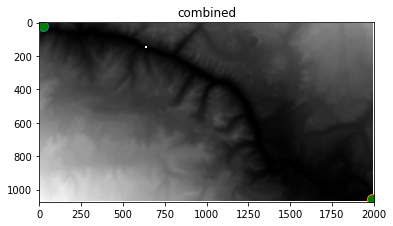

In [69]:


for i in range(n):
    for j in range(m):
        if np_bin_combined[i][j]!=math.inf and  round(np_bin_combined[i][j])==round(minval):
            np_bin_combined[i][j]=math.inf


plt.imshow(np_bin_combined,cmap='gray')
plt.plot([src_idx_x], [src_idx_y], marker="o", markersize=10, markerfacecolor="green")
plt.plot([des_idx_y], [des_idx_x], marker="o", markersize=10, markerfacecolor="green")
plt.title("combined")
plt.show()